# This is a notebook that walks through the basic analysis and plotting of data from a standard PEM water electrolyzer test

## Kara Ferner
## 9/12/2025

### 1. Import packages and set matplotlib settings

In [78]:
#Import Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import math
import os
from skimage import io
from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

In [128]:
#Import all (*) the functions from pemwe_analysis.py
import pemwe_analysis
from importlib import reload
reload(pemwe_analysis)  # reloads the updated module
from pemwe_analysis import *

In [80]:
# Matplotlib plotting controls

params = {'figure.autolayout': True,
          'figure.titleweight': 'normal',
          'lines.markersize': 8,
          'lines.markeredgewidth': 1,
          'lines.linewidth': 2,
          'font.weight': 'normal',
          'font.size': 14,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'legend.fontsize': 12,
          'legend.title_fontsize':12,
          'figure.figsize': (6, 5),
          'figure.titlesize': 14,
          'axes.labelsize': 12,
          'axes.labelweight': 'normal',
          'axes.titlesize': 14,
          'axes.linewidth': 1,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labeltop': False,
          'xtick.labelbottom': True,
          'ytick.left': True,
          'ytick.right': True,
          'ytick.labelright': False,
          'ytick.labelleft': True,
          'ytick.major.size': 5.5,
          'ytick.major.width': 0.8,
          'xtick.major.size': 5.5,
          'xtick.major.width': 0.8,
          'ytick.minor.size': 3.5,
          'ytick.minor.width': 0.6,
          'xtick.minor.size': 3.5,
          'xtick.minor.width': 0.6,
        'xtick.minor.visible':True,
         'ytick.minor.visible':True,
         'savefig.dpi': 1000,
#          'text.usetex':False
         }
rcParams.update(params)

### 2. Add variables for your sample name, label, loadings, plot color, etc

In [81]:
MEA_01_name = 'Example MEA 01'
MEA_01_Ir_loading = 0.0949 #mg/cm2
MEA_01_Pt_loading = 1.009 #mg/cm2
MEA_01_label = "0.09 mg$_{\\rm Ir}$ cm$^{-2}$, 1.01 mg$_{\\rm Pt}$ cm$^{-2}$"
MEA_01_color = 'red'

### 3. Use functions from pemwe_analysis.py to read, parse, and store data from the raw .txt files, then plot

#### 3.a. Raw data

In [82]:
#path to where your data is
path = './example_data/Example_MEA_01/'

#to work with the raw data, say from the LowIV_CP:
MEA_01_raw_data = get_raw_data(get_filenames(path+'LowIV_CP'))
MEA_01_raw_data

,Ewe/V,i/Acm-2,Ns,time/s
0,0.888629,0.001042,0,0.1000
1,0.889871,0.001018,0,0.2000
2,0.891399,0.001022,0,0.3000
3,0.892904,0.001017,0,0.4000
4,0.894361,0.001023,0,0.5000
...,...,...,...,...
20409,1.468927,0.080110,13,2039.7527
20410,1.468945,0.080089,13,2039.8527
20411,1.468946,0.080108,13,2039.9527
20412,1.468948,0.080105,13,2040.0527


#### 3.b. Polarization curves

In [83]:
#path to where your data is
path = './example_data/Example_MEA_01/'

#For polarization curves from a chronopotentiometry (CP) test
MEA_01_LowIV_CP = getPolCurve_CP(get_filenames(path+'LowIV_CP'))
MEA_01_HighIV_CP = getPolCurve_CP(get_filenames(path+'HighIV_CP'))
MEA_01_HighIV_CP

,Ewe/V,i/Acm-2,Ns
0,1.47965,0.10344,0.0
1,1.530462,0.30384,1.0
2,1.56882,0.5041,2.0
3,1.603126,0.703411,3.0
4,1.636171,0.904054,4.0
5,1.668013,1.104357,5.0
6,1.698638,1.304756,6.0
7,1.728834,1.504,7.0
8,1.757809,1.70432,8.0
9,1.787239,1.904687,9.0


In [84]:
# #For polarization curves from a galvanostatis EIS test (GEIS)
MEA_01_LowIV_GEIS = getPolCurve_GEIS(get_filenames(path+'LowIV_GEIS'))
MEA_01_HighIV_GEIS = getPolCurve_GEIS(get_filenames(path+'HighIV_GEIS'))
MEA_01_HighIV_GEIS

,Ewe/V,i/Acm-2,Ns,HFR/Ohmcm2,Ehfr-free/V
0,1.478366,0.103793,0.0,0.121342,1.465701
1,1.527807,0.303914,1.0,0.121334,1.490723
2,1.567088,0.504219,2.0,0.121588,1.505563
3,1.602856,0.703324,3.0,0.121730,1.517036
4,1.636886,0.904102,4.0,0.121969,1.526567
5,1.669356,1.104439,5.0,0.121906,1.534591
6,1.700907,1.304815,6.0,0.121968,1.541692
7,1.731661,1.503991,7.0,0.121880,1.548142
8,1.761548,1.704527,8.0,0.121729,1.55356
9,1.791319,1.904821,9.0,0.122923,1.558891


In [126]:
# If your GEIS data contains the up+down curves and you want to find the average and std at each point:
MEA_01_LowIV_GEIS_avg = split_and_average(MEA_01_LowIV_GEIS)
MEA_01_HighIV_GEIS_avg = split_and_average(MEA_01_HighIV_GEIS)

# If you want to combine the low and high current data into one dataframe:
MEA_01_IV = pd.concat([MEA_01_LowIV_GEIS_avg,MEA_01_HighIV_GEIS_avg])
MEA_01_IV


,Ewe/V,i/Acm-2,HFR/Ohmcm2,Ehfr-free/V,Ewe/V_std,i/Acm-2_std,HFR/Ohmcm2_std,Ehfr-free/V_std
0,1.389818,0.001042,0.119823,1.389692,0.003747,0.0,0.000179,0.003747
1,1.400256,0.002049,0.119780,1.40001,0.003915,0.0,0.000199,0.003915
2,1.406803,0.00304,0.119842,1.406437,0.003468,0.0,0.000030,0.003468
3,1.411186,0.004048,0.119827,1.410699,0.0033,0.0,0.000041,0.0033
4,1.414961,0.005041,0.120251,1.414354,0.003251,0.0,0.000820,0.003251
5,1.417876,0.006054,0.119774,1.417147,0.003256,0.000001,0.000055,0.003256
6,1.420471,0.007043,0.119816,1.419623,0.003168,0.0,0.000049,0.003168
7,1.422856,0.00805,0.120256,1.421887,0.003029,0.0,0.000413,0.003029
8,1.425236,0.009042,0.120048,1.424147,0.003255,0.000001,0.000060,0.003255
9,1.427392,0.010049,0.120494,1.426182,0.003168,0.0,0.000742,0.003168


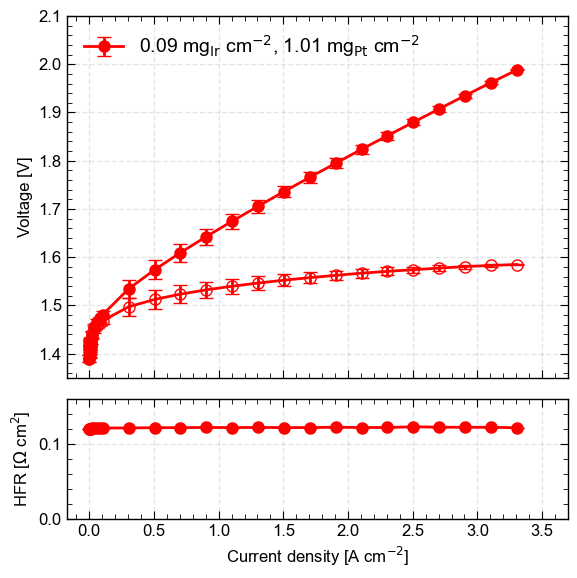

In [144]:
# plot it

fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, sharey=False,sharex=True,
                              gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,6))

ax1.errorbar(MEA_01_IV['i/Acm-2'], MEA_01_IV['Ewe/V'], 
             yerr=2*MEA_01_IV['Ewe/V_std'],
             fmt='o-', color=MEA_01_color, label=MEA_01_label, 
             capsize=5
            )

ax1.errorbar(MEA_01_IV['i/Acm-2'], MEA_01_IV['Ehfr-free/V'],
             yerr=2*MEA_01_IV['Ehfr-free/V_std'],
             fmt='o-',markerfacecolor="white", 
             fillstyle='none',
             capsize=5,
             color=MEA_01_color
            )

# -------------------------------

ax2.errorbar(MEA_01_IV['i/Acm-2'], MEA_01_IV['HFR/Ohmcm2'],
             yerr = 2*MEA_01_IV['HFR/Ohmcm2_std'],
            fmt='o-',
             capsize=5,
        color=MEA_01_color, label=MEA_01_label)


ax1.set_ylabel('Voltage [V]')
ax1.set_ylim([1.35,2.1])

ax2.set_ylabel('HFR [$\Omega$ cm$^{2}$]')
ax2.set_ylim([0,0.16])

plt.xlim([-0.175, 3.7])
plt.xlabel('Current density [A cm$^{-2}$]')

legend = ax1.legend(fontsize=14,
                   frameon=False,
                    loc = 'upper left',
                   bbox_to_anchor=(0,1)
                   )

ax1.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax2.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
plt.show()


#### 3.c. Tafel equation fitting and plotting

In [154]:
# Select low current data to use for Tafel plot and Tafel equation fitting

MEA_01_data_for_tafel_plot = MEA_01_IV[MEA_01_IV['i/Acm-2'] < 0.1 ] 
MEA_01_data_for_tafel_fit = MEA_01_IV[MEA_01_IV['i/Acm-2'] < 0.02 ] 

popt_MEA_01,_ = curve_fit(tafel,MEA_01_data_for_tafel_fit['i/Acm-2'],MEA_01_data_for_tafel_fit['Ehfr-free/V'],p0=(0.040,10**-9))
print("Tafel slope: {:.3f} V/dec \ni0: {:.3g} Acm-2".format(*popt_MEA_01))



Tafel slope: 0.037 V/dec 
i0: 2.43e-09 Acm-2


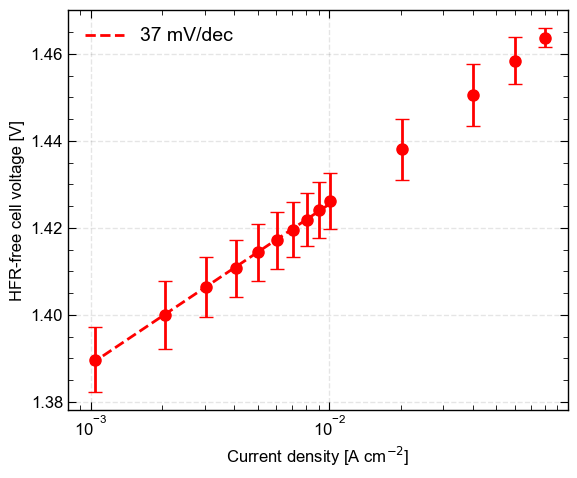

In [ ]:
# Plot HFR-free voltage vs. current density on semi-log plot:

fig, ax = plt.subplots(figsize=(6,5))

ax.errorbar(MEA_01_data_for_tafel_plot['i/Acm-2'], MEA_01_data_for_tafel_plot['Ehfr-free/V'],
        yerr=2*MEA_01_data_for_tafel_plot['Ehfr-free/V_std'],
        fmt='o', 
        capsize=5,
        color=MEA_01_color)

#plot the Tafel equation with the fit parameters

tafel_eq_x = np.logspace(-3,-2)
ax.plot(tafel_eq_x,tafel(tafel_eq_x,*popt_MEA_01), '--',color=MEA_01_color,label='{:.0f} mV/dec'.format(popt_MEA_01[0]*1000))

ax.set_ylabel('HFR-free cell voltage [V]')
ax.set_xlabel('Current density [A cm$^{-2}$]')

ax.set_xscale('log')


ax.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)

ax.legend(loc='best', fontsize=14, frameon=False)

plt.show()


#### 3.d. CV plotting

#### 3.e. Nyquist plotting